In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide();
    } 
    else {
        $('div.input').show();
    }
    code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [17]:
from IPython.display import Image
from Bio.Seq import Seq, transcribe, translate
from Bio import SeqIO, AlignIO, Align, SeqRecord
from collections import Counter
import dendropy

ModuleNotFoundError: No module named 'dendropy'

## Project Lab Notebook
### Marina Herrera Sarrias


### Date: 2018-12-21

### *Project Setup*

### **1.** Define project Layout:

Top level organization: protein_multial_noise_reduction<br>

./doc/ <br>
./data/<br>
./src/<br>
./bin/<br>
./results/<br>

**NOTE: What will contain each folder?**


### **2.** Create a github repository for version control:

__[https://github.com/msarrias/protein_multial_noise_reduction](https://github.com/msarrias/protein_multial_noise_reduction)__


### **3.** Download fixed test data sets:

The test dataset was downloaded from __[Canvas](https://kth.instructure.com/courses/6158/files/1383925/download?wrap=1)__ and unpacked using the following command line:



./data/ <br>
$\qquad$./data/appbio11/<br>


As the whole project will be performed only with the data sets contained in appbio11, we wont follow a chronological organization for the data directory. (adviced on the __[Course centerpice](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000424#s8)__) but we will rename the directory to *raw_data*.


**raw_data:** containes six subdirectories:

./raw_data/ <br>
$\qquad$./raw_data/asymmetric_0.5/<br>
$\qquad$./raw_data/asymmetric_1.0/<br>
$\qquad$./raw_data/asymmetric_2.0/<br>
$\qquad$./raw_data/symmetric_0.5/<br>
$\qquad$./raw_data/symmetric_1.0/<br>
$\qquad$./raw_data/symmetric_2.0/<br>



### Date: 2018-12-23

### *Find and Remove Noisy colums*

### **1.**  Find the noise:

We will firstly generate a function for identifying all of those noisy columns. In this project, a column is considered noisy if:<br>

* there are more than 50% indels,<br>
* at least 50% of amino acids are unique,<br>
* no amino acid appears more than twice.<br>




### **Test data:**

In [3]:
s001_align = '../data/raw_data/asymmetric_0.5/s001.align.1.msl'

In [71]:
with open(s001_align, mode='r') as aligned_file:
    my_sequence_recorded = AlignIO.read(aligned_file, 'fasta')

### **Reading the alignment:**

In [6]:
print(my_sequence_recorded)

SingleLetterAlphabet() alignment with 16 rows and 445 columns
KRKPGTTKTKRG-----LESKTKTKRKTSLFIAREQKDLDGMGE...IVG sp2
TAKP-PNSTRRG----MLDGRLKTKRKEKLFLARGNKDIDGMGE...VGG sp11
SSKP-SRSKHRG-----FHGRLKTKRKDKLFLARANKDLDGMGE...VEG sp7
KYKP-PSSEKRGGKAVGFLGRPKTKRKNNLFLSRSKKDLDGMGE...KLG sp6
SVKP-PSTTART-----LNGRRKTKRKENLFLARSGKDLDGMGE...LRG sp10
RKKP-PPSRKRG-----FNGQLKTKRKDKLFLPRSVKDLDGMGE...VLG sp16
NAKP-PS---RG-----LSGRLKTKRKDGLFLARSAKDLDGMGE...ILG sp3
SPKP-PPSSRRG-----FNGRSKTKRKE-LFLARHNKDLDGMGE...VLG sp15
DNKA-PPGSKRG-----FNGRLNTKRKDNLFVASSTKDLDGMGE...VLG sp4
KTKP-PPSRKRG-----FNGRLKTKRKDNLFLARSNKDLDGMGE...VLG sp5
SAKV-TPGPRRA-----LKGRQKTKAKAALFLARTDKDLDGMGE...AKG sp9
SAKV-PPGPRRG-----LNGRAKTKRKENLFLARTNKDLDGMGE...LMG sp8
QTKV-PPGSRRG-----LNGRQDTKRKEGLFLARTKKDLDGMGE...LMG sp12
SARV-PPGARRG-----FSGRQKTKRKQGLFLARTNKDLDGMGE...LMG sp1
NAKV-PPGSRRG-----LNGRQKTKRKQGLFLARTNKDLDGMGE...LMG sp13
SAKV-PPGSRRG-----LSGRQKTKRKQGLFLARTNKDLDGMGE...LMG sp14


Each column is composed by aminoacids on a given alligned sequence position, i.e the first column of the test data will be: 

In [7]:
print((my_sequence_recorded[:, 0]))

KTSKSRNSDKSSQSNS


where the length will depend on the number of sequences that are being alligned in this case:

In [9]:
print(len(my_sequence_recorded))

16


### noise_filter function:

In [47]:
def noise_filter(column):
    """
    noise_filter is a function that determines whether an alignment column is noisy or not.
    :param column: multiple sequence alignment column.
    :return: boolean.
    """
    indel = '-'
    amino_counter = Counter(column)
    if column.count(indel) > len(column) / 2:
        return True
    if len([key for key, value in amino_counter.items() if value == 1 ]) >= len(column) / 2:
        return True
    if max(amino_counter.values()) <= 2:
        return True
    return False     

following the test data example:

In [13]:
column1 = my_sequence_recorded[:, 0]

In [44]:
print(noise_filter(column1))

False


### reduce_noise function:

In [155]:
def reduce_noise(multiple_seq_alignment):
    """
    reduce_noise is a function that filters all noisy columns.
    :param multiple_seq_alignment: MultipleSeqAlignment.
    :return: a MultipleSeqAlignment.
    """
    noise_free_column_list = []
    new_aligned_list = []
    for i in range(my_sequence_recorded.get_alignment_length()):
        if not noise_filter(my_sequence_recorded[:, i]):
            noise_free_column_list.append(my_sequence_recorded[:, i])
    for i in range(len(my_sequence_recorded)):
        new_aligned_list.append(''.join([x[i] for x in noise_free_column_list]))
    record_list = Align.MultipleSeqAlignment([
        SeqRecord.SeqRecord(Seq(new_seq), id=record.id, name=record.name, description=record.description)
        for new_seq, record in zip(new_aligned_list, my_sequence_recorded)
     ])

following the test data example: 

In [165]:
reduce_noise(my_sequence_recorded)
print(record_list)

Alphabet() alignment with 16 rows and 369 columns
KRKPTTKTKRGLESKTKTKRKTSLFIAREQKDLDGMGERQLDPH...IVG sp2
TAKPPNSTRRGLDGRLKTKRKEKLFLARGNKDIDGMGERELNPH...VGG sp11
SSKPSRSKHRGFHGRLKTKRKDKLFLARANKDLDGMGERELDPH...VEG sp7
KYKPPSSEKRGFLGRPKTKRKNNLFLSRSKKDLDGMGERQLDPH...KLG sp6
SVKPPSTTARTLNGRRKTKRKENLFLARSGKDLDGMGERQLNPH...LRG sp10
RKKPPPSRKRGFNGQLKTKRKDKLFLPRSVKDLDGMGERELDPH...VLG sp16
NAKPPS---RGLSGRLKTKRKDGLFLARSAKDLDGMGERELDPH...ILG sp3
SPKPPPSSRRGFNGRSKTKRKE-LFLARHNKDLDGMGERELNPH...VLG sp15
DNKAPPGSKRGFNGRLNTKRKDNLFVASSTKDLDGMGERELDPH...VLG sp4
KTKPPPSRKRGFNGRLKTKRKDNLFLARSNKDLDGMGERELDPH...VLG sp5
SAKVTPGPRRALKGRQKTKAKAALFLARTDKDLDGMGERQANPH...AKG sp9
SAKVPPGPRRGLNGRAKTKRKENLFLARTNKDLDGMGERQLNPH...LMG sp8
QTKVPPGSRRGLNGRQDTKRKEGLFLARTKKDLDGMGERQLNPH...LMG sp12
SARVPPGARRGFSGRQKTKRKQGLFLARTNKDLDGMGERQLNPH...LMG sp1
NAKVPPGSRRGLNGRQKTKRKQGLFLARTNKDLDGMGERQLNPH...LMG sp13
SAKVPPGSRRGLSGRQKTKRKQGLFLARTNKDLDGMGERQLNPH...LMG sp14


### Writing a file:

In [166]:
AlignIO.write(record_list, "s001_align_test_rn.fasta", "fasta")

1

### Results:

We use SeaView as an interface for multiple sequence alignment. Following the test data example, the first image below represents the multialignment without protein noise reduction, while the second one the multialignment after the noise reduction.

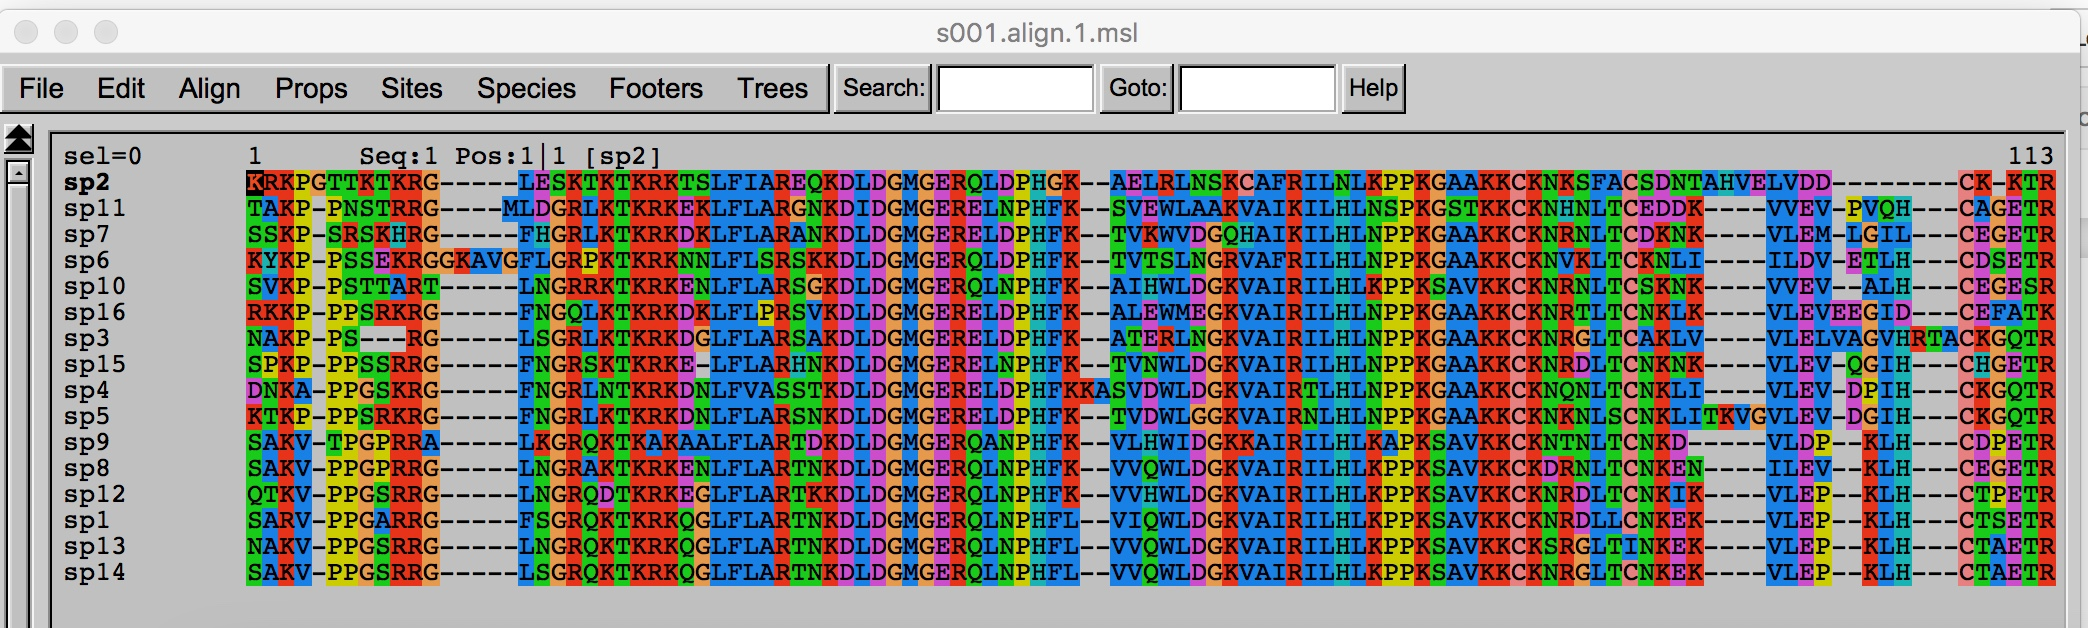

In [168]:
Image("labnotes_2_1.png")

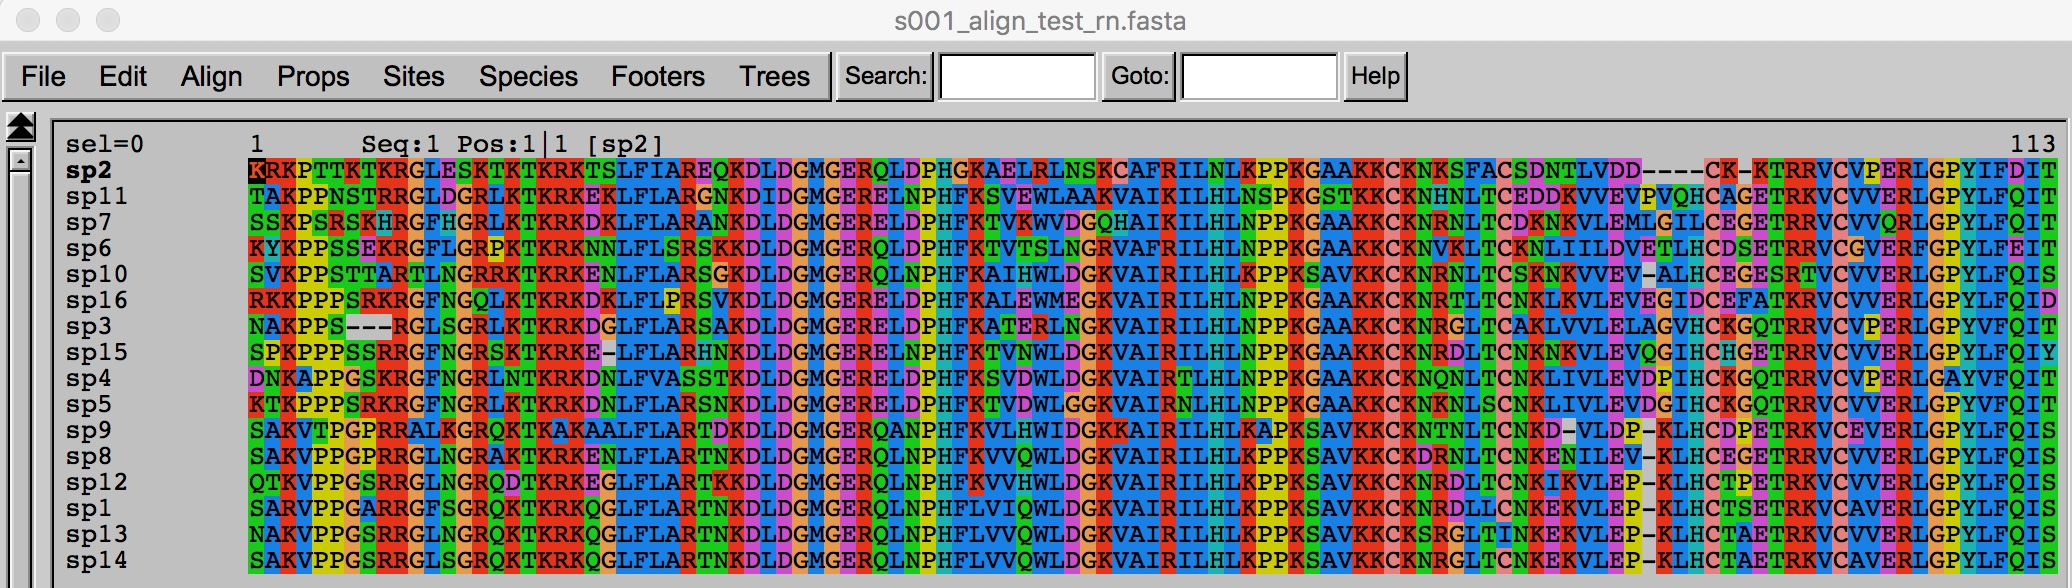

In [169]:
Image("labnotes_2_2.png")

### Date: 2018-12-24

## *Setting up fastphylo*

## Data test: asymmetric_2.0/s001.align.1.msl

Using **fastprot** we can obtain a distance matrice:

Using **fnj** we can obtain the tree:

I noticed that the resulting tree did not included the branches length, therefore after some researche I found someone else had the same problem:
__[Reconstruction Methods](https://github.com/arvestad/FastPhylo/issues/1)__


I then tried the BIONJ method, which is an improved version of the NJ (neighbor-joining) algorithm based on a simple model of sequence data. 
__[extra info about Reconstriction Methods](https://www.researchgate.net/publication/259700682_Phylogenetic_Reconstruction_Methods_An_Overview)__

